# Disease Impact on Cardiac Proliferation and Regeneration Pathway Regulation

### In this notebook, I will work towards extracting the necessary data for a ReactomeGSA Pathway analysis that will help identify the cardiac proliferation and regeneration pathways that are upregulated and downregulated as a result of disease. Comparing the differential regulation of the analyzed pathways (as well as protein fold changes) to their CaseOLAP values can provide insight into the extent to which these proteins and pathways are reflected in the biomedical literature and perhaps guide the focus of future cardiac research.

###### 1) I will extract all of the UniProt IDs of the proteins that were identified in the samples that I had selected for an Integrated Proteomics Pipeline (IP2) analysis. The samples will then be separated into two groups: 1) proteins from heart disease samples and 2) proteins from non-heart disease samples.
###### 2) After obtaining the list of genes implicated in cardiac proliferation and regeneration from the scRNA analysis conducted previously, these genes will be mapped to UniProtKB IDs. I can then determing which proteins in the heart disease protein group and the non-disease group are involved in cardiac proliferation and generation. A Reactome pathway analysis will be run on the proteins on the proliferation/regeneration proteins that are not present in both groups. This will help gain insight into any uniquenesses found in either group. 
###### 3) Only two experiments from the PRoteomics IDEntification Database will be used to elucidate proliferation/regeneration pathways whose regulation are impacted by disease. The end of this notebook will include an extraction of the protein quantification data used for this ReactomeGSA analysis.
###### 4) Lastly, I will compare previously generated CaseOLAP values of cardiac proteins to the protein and pathway fold change values extracted from the IP2 analysis and ReactomeGSA analyses, respectively. 

In [106]:
!ls
! unzip All_Data-20221114T223200Z-001.zip

All_Data				    TMT_for_Reactome.csv
All_Data-20221114T223200Z-001.zip	    UniProt2Reactome_All_Levels.txt
Data					    UniProt2Reactome_All_Levels.txt.1
Kaitlyn_NCBI_Gene_to_UniProt.ipynb	    UniProt2Reactome_All_Levels.txt.2
Multi-Omics-Proteomics-Integration	    UniProt2Reactome_All_Levels.txt.3
ProteinExtraction_Fall2022-Copy1.ipynb	    caseolap_integration
ProteinExtraction_Fall2022.ipynb	    non_prolif_regen_control.txt
ReactomeResults_DiffReg.csv		    non_prolif_regen_disease.txt
Spec_for_Reactome.csv			    non_prolif_regen_total.txt
SupplementaryData2_Summary_Table-Copy1.csv
Archive:  All_Data-20221114T223200Z-001.zip
replace All_Data/Prosser_1366.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [107]:
!ls Data/

PXD008934_Experiment  TMT2_Intensities.csv
PXD011349_Experiment  absolute_genes.txt
PXD018678_Experiment  gene_name_to_uniprot_id.json
PXD023778_Experiment  proteins_for_proliferation-regeneration_pathways.txt
TMT1_Intensities.csv  sample_for_reactome.txt


## Protein Counts in Each Experiment
### Here I will extract the proteins from each experiment and determine the number of protein overlaps between every experiment combination. I will also be able to find the number of nonredundant heart disease related proteins and nonredundant proteins from non-heart disease samples across all experiments. 

In [108]:
# Create a function to extract protein and spectral counts in the text files
def extract_protein_and_spec(file_with_prots_and_spec: list) -> list:
    proteins = []
    spec_counts = []
    for line in file_with_prots_and_spec:
        if '|' in line:
            #print(line)
            protein_name = line.split('|')[1]
            proteins.append(protein_name)
            count = line.split('\t')[2]
            spec_counts.append(count)
    return proteins, spec_counts


In [109]:
import os

def load_data(data_folder='./data', debug=False):
    DISEASE_TAG = "Disease"
    CONTROL_TAG = "Control"
    EXPERIMENT_TAG = "Experiment"
    
    # This dict maps experiment name --> list of files
    experiment_to_data_files = {}
    
    # This dict maps experiment name --> list of nonredundant proteins for that experiment
    experiment_to_proteins = {}
    
    # This dict maps experiment name --> number of total nonredundant proteins for the investigation
    experiment_to_protein_counts = {}
    
  
    total_proteins = []  #proteins across all experiments
    disease_prots = []   #proteins found in disease samples
    control_prots = []  #proteins found in control samples
    
    # loop through all folders in data folder; contains experiment folders
    for file in os.listdir(data_folder): 
        
        #is it an experiment folder or not?
        is_experiment = EXPERIMENT_TAG in file
        
        
        # if it is an experiment, get path to that experiment
        if is_experiment:
            
            experiment_folder = os.path.join(data_folder, file)
            
            all_files = []
            all_nonredundant_proteins = []
            
       
            # loop through all files in the experiment folder
            for data_file in os.listdir(experiment_folder):
            
                data_file_path = os.path.join(experiment_folder, data_file) #e.g. ./data/PXDXXX/Prosser_XXX.txt
            
                if data_file != '.ipynb_checkpoints':
                    
                    all_files += [data_file]
            
                    # store experiment -> list of files
                    experiment_to_data_files[file] = all_files
                
                    open_data_file = open(data_file_path, 'r').read().split("\n")

                    #extract the protein list for this data_file
                    protein_list = extract_protein_and_spec(open_data_file)[0]

                    for prot in protein_list:
                        if prot not in all_nonredundant_proteins:
                            all_nonredundant_proteins.append(prot)
                        if prot not in total_proteins:
                            if len(prot) > 0:
                                total_proteins.append(prot)
                        if DISEASE_TAG in data_file:
                            if prot not in disease_prots:
                                if len(prot) > 0:
                                    disease_prots.append(prot)
                        if CONTROL_TAG in data_file:
                            if prot not in control_prots:
                                if len(prot) > 0:
                                    control_prots.append(prot)
                    
            prots_count = len(all_nonredundant_proteins)
            
            #store experiment -> list of nonredundant proteins
            experiment_to_proteins[file] = all_nonredundant_proteins
            
            #store experiment -> nonredundant protein count for that file
            experiment_to_protein_counts[file] = prots_count
            
    return experiment_to_data_files, experiment_to_proteins, experiment_to_protein_counts, total_proteins, control_prots, disease_prots
        
data_folder = './Data'

experiment_to_data_files, experiment_to_proteins, experiment_to_protein_counts, total_proteins, control_prots, disease_prots = load_data(data_folder)

print("We have extracted a total of %s nonredundant proteins." %len(total_proteins))
print("The non-heart disease samples include a total of %s nonredundant proteins." %len(control_prots))
print("The heart disease samples include a total of %s nonredundant proteins." %len(disease_prots))

We have extracted a total of 3956 nonredundant proteins.
The non-heart disease samples include a total of 1622 nonredundant proteins.
The heart disease samples include a total of 3921 nonredundant proteins.


In [110]:
#identifying the proteins that are in both lists

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
 
both_disease_and_control = intersection(control_prots, disease_prots)

print("There are %s nonredundant proteins that are found in both heart disease and non-heart disease groups." %len(both_disease_and_control))

There are 1587 nonredundant proteins that are found in both heart disease and non-heart disease groups.


In [111]:
from itertools import combinations

#this function generations all combinations of experiment names for later use
def get_combinations(my_list):
    combs = []
    for size in (range(2,len(my_list)+1)):
        combs += list(combinations(my_list,size))
    
    return combs

combs = get_combinations(experiment_to_data_files.keys())
combs

[('PXD011349_Experiment', 'PXD018678_Experiment'),
 ('PXD011349_Experiment', 'PXD023778_Experiment'),
 ('PXD011349_Experiment', 'PXD008934_Experiment'),
 ('PXD018678_Experiment', 'PXD023778_Experiment'),
 ('PXD018678_Experiment', 'PXD008934_Experiment'),
 ('PXD023778_Experiment', 'PXD008934_Experiment'),
 ('PXD011349_Experiment', 'PXD018678_Experiment', 'PXD023778_Experiment'),
 ('PXD011349_Experiment', 'PXD018678_Experiment', 'PXD008934_Experiment'),
 ('PXD011349_Experiment', 'PXD023778_Experiment', 'PXD008934_Experiment'),
 ('PXD018678_Experiment', 'PXD023778_Experiment', 'PXD008934_Experiment'),
 ('PXD011349_Experiment',
  'PXD018678_Experiment',
  'PXD023778_Experiment',
  'PXD008934_Experiment')]

In [112]:
import pandas as pd

#this function generations a dataframe to indicate whether a protein is found within an experiment or combination of experiments
def protein_distribution(all_proteins, experiment_combinations, experiment_to_proteins):
    
    #all of the proteins will be in the index column of this dataframe
    df = pd.DataFrame(all_proteins)
    df = df.rename(columns = {0: 'All Proteins'})
    df = df.set_index('All Proteins')
    
    #converting experiment_to_proteins dict to a list
    exp_to_prots_list = list(experiment_to_proteins.values())
    
    # Write if protein is present in a given list
    for i, j in zip(experiment_to_proteins.keys(), range(4)):
        df[i] = [True if x in exp_to_prots_list[j] else False for x in all_proteins]
        
    for combination in experiment_combinations:
        
        #access the data in the experiment columns of current interest
        experiments_interest = [x for x in combination]
        
        #if the experiments of interest have the protein and 
        df[combination] = ((df[experiments_interest]).all(bool_only=True,axis='columns')) 
    
    return df

protein_distribution = protein_distribution(total_proteins, combs, experiment_to_proteins)

protein_distribution

# counts = []
# for col_name in df.columns:
#     counts.append(df[col_name].sum())
    
# counts

,PXD011349_Experiment,PXD018678_Experiment,PXD023778_Experiment,PXD008934_Experiment,"(PXD011349_Experiment, PXD018678_Experiment)","(PXD011349_Experiment, PXD023778_Experiment)","(PXD011349_Experiment, PXD008934_Experiment)","(PXD018678_Experiment, PXD023778_Experiment)","(PXD018678_Experiment, PXD008934_Experiment)","(PXD023778_Experiment, PXD008934_Experiment)","(PXD011349_Experiment, PXD018678_Experiment, PXD023778_Experiment)","(PXD011349_Experiment, PXD018678_Experiment, PXD008934_Experiment)","(PXD011349_Experiment, PXD023778_Experiment, PXD008934_Experiment)","(PXD018678_Experiment, PXD023778_Experiment, PXD008934_Experiment)","(PXD011349_Experiment, PXD018678_Experiment, PXD023778_Experiment, PXD008934_Experiment)"
All Proteins,,,,,,,,,,,,,,,
P62805,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
P17661,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Q01995,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
P35908,True,True,False,True,True,False,True,False,True,False,False,True,False,False,False
P62258,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P08579,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
Q8NI37,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
O15143,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False


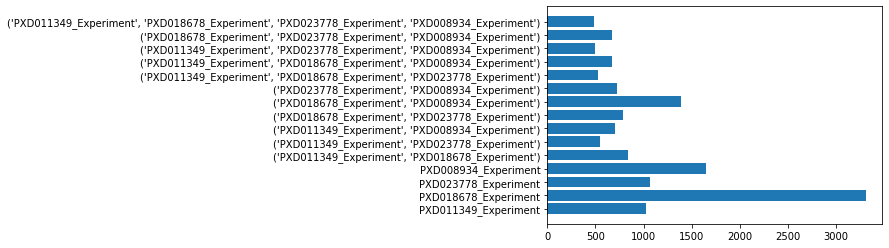

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [113]:
import matplotlib.pyplot as plt
import numpy as np

#this function generates a bar graph of the protein distributions in the experiments

def plot_prots_distribution(df):
    
    #obtaining counts for each column
    counts = []
    for col_name in df.columns:
        counts.append(df[col_name].sum())
        
    Y_axis = np.arange(len(df.columns))
    plt.barh(Y_axis, counts)
    plt.yticks(Y_axis, df.columns)
    plt.show()
    
    return plt

combintations_bargraph = plot_prots_distribution(protein_distribution)

combintations_bargraph

[Text(0.5, 14.09375, 'Experiment')]

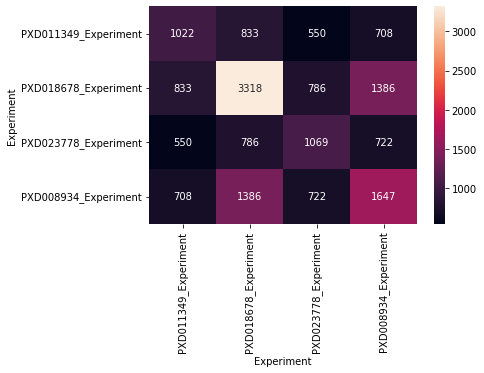

In [114]:
#this function generates a heatmap to visualize how many proteins are shared between experiment pairs

import seaborn as sns
import pandas as pd

def experiment_pairs_heatmap(experiment_to_proteins):
    
    #all of the proteins will be in the index column of this dataframe
    df_for_heatmap = pd.DataFrame(experiment_to_proteins.keys())
    df_for_heatmap = df_for_heatmap.rename(columns = {0: 'Experiment'})
    df_for_heatmap = df_for_heatmap.set_index('Experiment')
    
    #populating the dataframe with the correct values for heatmap generation
    for exp1 in experiment_to_proteins.keys():
        new_col_values = []
        for exp2 in experiment_to_proteins.keys():
            counter = 0
            for prot in experiment_to_proteins[exp1]:
                    if prot in experiment_to_proteins[exp2]:
                        counter = counter + 1
            new_col_values.append(counter)
        df_for_heatmap[exp1] = new_col_values
    
    #plotting the heatmap
    plot = sns.heatmap(df_for_heatmap, annot = True, fmt='.4g')
    plot = plot.set(xlabel = "Experiment")
    
    return plot

pairs_heatmap = experiment_pairs_heatmap(experiment_to_proteins)

pairs_heatmap

# Proteins Not Related to Proliferation/Regeneration in Heart Disease Samples and Non-Heart Disease Samples

### An investigation into the double-injury model in neonate pigs allowed for the generation of scRNA data. Genes implicated in proliferation/generation were extracted and compared to the heart disease and non-heart disease samples. 

In [115]:
#extracting the proliferation/generation protein data

import json
def proliferation_regeneration(file_path):
    with open(file_path, 'r') as f:
        from_genes = json.load(f)

    prolif_regen_prots = list(from_genes.values())

    all_prolif_regen_prots = []

    for items in prolif_regen_prots:
        for item in items:
            all_prolif_regen_prots.append(item)
    return all_prolif_regen_prots

all_prolif_regen_prots = proliferation_regeneration('./Data/gene_name_to_uniprot_id.json')
        
print("From the scRNA data we have obtained %s proteins." %len(all_prolif_regen_prots))
print("%s total proteins are proliferation/regeneration proteins." %len(intersection(total_proteins, all_prolif_regen_prots)))
print("%s total proteins are not proliferation/regeneration proteins." %(len(total_proteins) - len(intersection(total_proteins, all_prolif_regen_prots))))
print("The fraction of total proteins that are not proliferation/regeneration proteins is %s." %(1-((len(intersection(total_proteins, all_prolif_regen_prots)))/(len(disease_prots)))))
print("%s proteins in the non-heart disease group are proliferation/regeneration proteins." %len(intersection(control_prots, all_prolif_regen_prots)))
print("%s proteins in the non-heart disease group are not proliferation/regeneration proteins." %(len(control_prots) - len(intersection(control_prots, all_prolif_regen_prots))))
print("%s proteins in the heart disease group are proliferation/regeneration proteins." %len(intersection(disease_prots, all_prolif_regen_prots)))
print("%s proteins in the heart disease group are not proliferation/regeneration proteins." %(len(disease_prots) - len(intersection(disease_prots, all_prolif_regen_prots))))
print("The fraction of proteins in the non-heart disease group that are not proliferation/regeneration proteins is %s." %(1-((len(intersection(control_prots, all_prolif_regen_prots)))/(len(control_prots)))))
print("The fraction of proteins in the heart disease group that are not proliferation/regeneration proteins is %s." %(1-((len(intersection(disease_prots, all_prolif_regen_prots)))/(len(disease_prots)))))


From the scRNA data we have obtained 87005 proteins.
3389 total proteins are proliferation/regeneration proteins.
567 total proteins are not proliferation/regeneration proteins.
The fraction of total proteins that are not proliferation/regeneration proteins is 0.13567967355266508.
1406 proteins in the non-heart disease group are proliferation/regeneration proteins.
216 proteins in the non-heart disease group are not proliferation/regeneration proteins.
3362 proteins in the heart disease group are proliferation/regeneration proteins.
559 proteins in the heart disease group are not proliferation/regeneration proteins.
The fraction of proteins in the non-heart disease group that are not proliferation/regeneration proteins is 0.13316892725030827.
The fraction of proteins in the heart disease group that are not proliferation/regeneration proteins is 0.1425656720224433.


#### I am curious about the proteins that are not related to proliferation and regeneration in the different groups. I will conduct a Reactome pathway analysis on these proteins to gain more insight.

In [116]:
#extracting the proteins that are not related to proliferation and regeneration for Reactome analysis

def non_proliferation_regeneration(control_prots, disease_prots, all_prolif_regen_prots):

    non_prolif_regen_control = []
    for prot in control_prots:
        if prot not in all_prolif_regen_prots:
            non_prolif_regen_control.append(prot)
    
    non_prolif_regen_disease = []
    for prot in disease_prots:
        if prot not in all_prolif_regen_prots:
            non_prolif_regen_disease.append(prot)

    non_prolif_regen_total = []
    for prot in total_proteins:
        if prot not in all_prolif_regen_prots:
            non_prolif_regen_total.append(prot)

    return non_prolif_regen_control, non_prolif_regen_disease, non_prolif_regen_total

non_prolif_regen_control, non_prolif_regen_disease, non_prolif_regen_total = non_proliferation_regeneration(control_prots, disease_prots, all_prolif_regen_prots)

In [117]:
#writing them to a text file for use in Reactome analysis
with open('non_prolif_regen_control.txt', 'w') as f:
   for element in non_prolif_regen_control:
       f.write(element + '\n')
        
with open('non_prolif_regen_disease.txt', 'w') as f:
   for element in non_prolif_regen_disease:
       f.write(element + '\n')
        
with open('non_prolif_regen_total.txt', 'w') as f:
   for element in non_prolif_regen_total:
       f.write(element + '\n')

# Extraction of Protein Intensity Quantification Values for Reactome GSA Analysis

### Here I will prepare the files that I will used for the ReactomeGSA analysis. Only experiments PXD023778 and PXD008934 will be used for this portion of the investigation. The analysis will help determine how cardiac proliferation and regeneration pathways are impacted by the onset of disease.

PXD023778

In [118]:
import pandas as pd

def prepare_TMT(TMT1_csv, TMT2_csv, prolif_regen_prots):
    
    #load the csvs
    TMT1 = pd.read_csv(TMT1_csv)
    TMT2 = pd.read_csv(TMT2_csv)
    
    #create the accession to be the index in each of the dataframes
    TMT1 = TMT1.set_index('accession')
    TMT2 = TMT2.set_index('accession')
    
    #drop the columns that will not be needed for Reactome
    TMT1 = TMT1.drop(['spec count', 'peptide num', 'description'], axis=1)
    TMT2 = TMT2.drop(['spec count', 'peptide num', 'description'], axis=1)
    TMT1 = TMT1.loc[:,~TMT1.columns.str.contains('^avg', case=False)]
    TMT2 = TMT2.loc[:,~TMT2.columns.str.contains('^avg', case=False)]
    TMT2 = TMT2.add_suffix('_2')
    
    #merging the two dataframes into one
    TMT = pd.concat([TMT1, TMT2], axis=1)
    
    #removing rows with contaminants and reverse sequences
    TMT = TMT[TMT.index.str.contains("Reverse|contaminant") == False]
    
    #removing rows that are not proliferation or regeneration proteins
    for prot in TMT.index:
         if prot not in prolif_regen_prots:
              TMT = TMT[TMT.index.str.contains(prot) == False]
    
    #log2 transform the dataframe
    TMT = TMT.applymap(np.log2)
    
    return TMT

TMT = prepare_TMT('./Data/TMT1_Intensities.csv', './Data/TMT2_Intensities.csv', all_prolif_regen_prots)

TMT

,norm int m/z_126.127725,norm int m/z_127.12476,norm int m/z_128.134433,norm int m/z_129.131468,norm int m/z_130.141141,norm int m/z_131.138176,norm int m/z_126.127725_2,norm int m/z_127.12476_2,norm int m/z_128.134433_2,norm int m/z_129.131468_2,norm int m/z_130.141141_2,norm int m/z_131.138176_2
accession,,,,,,,,,,,,
P05413,21.707530,21.844632,21.483896,22.185584,21.753813,21.795066,21.827544,21.975741,21.545391,22.364311,21.867103,21.904687
Q99623,20.025080,20.121633,20.086952,20.102822,20.147055,20.066549,19.964762,19.993694,19.976327,20.087602,20.083529,20.065778
P04792,19.518296,19.847542,19.704428,19.812520,19.751481,19.893138,19.764996,20.185596,20.021808,20.182164,20.084169,20.278700
P99999,19.783661,20.070656,19.660202,19.968243,20.130078,19.769371,19.919097,20.150686,19.797287,20.263659,20.391596,19.989614
P07951,19.262036,19.442948,19.280226,19.175795,19.005510,19.054925,19.364869,19.513622,19.343981,19.284718,19.096441,19.193429
...,...,...,...,...,...,...,...,...,...,...,...,...
Q8NDA2,NaN,NaN,NaN,NaN,NaN,NaN,21.061802,21.038920,21.097628,21.125360,21.036021,21.125979
Q8NEZ4,NaN,NaN,NaN,NaN,NaN,NaN,17.481713,17.626561,17.389564,17.333474,17.779254,17.448741
Q9NYQ8,NaN,NaN,NaN,NaN,NaN,NaN,20.897750,21.300597,20.551512,20.015933,19.883925,20.273794


In [119]:
#writing dataframe to csv
TMT.to_csv("TMT_for_Reactome.csv")

PXD008934

In [120]:
import pandas as pd

def prepare_Prosser_files(data_folder, prolif_regen_prots):
  
    PXD008934_TAG = "PXD008934"
    counter = 0
    
    # loop through all folders in data folder
    for file in os.listdir(data_folder): 
        
        #is it correct experiment folder or not?
        is_PXD008934 = PXD008934_TAG in file
        
        if is_PXD008934:
            
            PXD008934_folder = os.path.join(data_folder, file)
            
            # loop through all files in the experiment folder
            for data_file in os.listdir(PXD008934_folder):
            
                counter = counter + 1
                
                data_file_path = os.path.join(PXD008934_folder, data_file) #e.g. ./data/PXDXXX/Prosser_XXX.txt
            
                if data_file != '.ipynb_checkpoints':
                
                    open_data_file = open(data_file_path, 'r').read().split("\n")

                    #extract the protein list for this data_file
                    protein_list = extract_protein_and_spec(open_data_file)[0]
                    
                    #extract the spec counts for this data_file
                    spec_counts = extract_protein_and_spec(open_data_file)[1]
                    
                    #This dict map protein name --> spec count
                    protein_to_spec_count = {}
                    
                    #populated the protein_to_spec_count dict:
                    for prot, spec_value in zip(protein_list, spec_counts):
                        protein_to_spec_count[prot] = spec_value
                        
                    if counter == 1:
                        df_spec_count = pd.DataFrame.from_dict(protein_to_spec_count, orient = 'index', columns = [data_file])
                        #spec_count_df = pd.concat([df_to_add, spec_count_df])
                        
                    if counter != 1:
                        df_to_add = pd.DataFrame.from_dict(protein_to_spec_count, orient = 'index', columns = [data_file])
                        df_spec_count = pd.concat([df_spec_count, df_to_add], axis = 1)
                        
    #removing rows that are not proliferation or regeneration proteins
    for prot in df_spec_count.index:
         if prot not in prolif_regen_prots:
            df_spec_count = df_spec_count[df_spec_count.index.str.contains(prot) == False]
        
    
    return df_spec_count
                        

data_folder = './Data'
df_spec_count = prepare_Prosser_files(data_folder, all_prolif_regen_prots)

df_spec_count

,Prosser_1383_Control.txt,Prosser_1195_Disease.txt,Prosser_1427_Disease.txt,Prosser_1136_Disease.txt,Prosser_1325_Control.txt,Prosser_1467_Disease.txt,Prosser_1119_Disease.txt,Prosser_1085_Control.txt,Prosser_1198_Disease.txt,Prosser_1228_Disease.txt,...,Prosser_1339_Control.txt,Prosser_1004_Disease.txt,Prosser_1602_Disease.txt,Prosser_1356_Control.txt,Prosser_1320_Disease.txt,Prosser_1209_Disease.txt,Prosser_1379_Disease.txt,Prosser_1304_Disease.txt,Prosser_1472_Disease.txt,Prosser_1086_Disease.txt
P05413,45,44,50,53,56,51,61,66,51,50,...,55,51,59,58,42,49,55,45,50,52
P56385,23,10,16,13,13,7,14,18,9,16,...,12,24,18,26,NaN,16,14,11,17,17
P09493,28,35,28,31,32,31,35,32,23,19,...,34,35,23,35,26,27,30,28,19,31
P07951,21,24,16,27,24,22,28,22,15,16,...,24,33,17,25,21,19,20,20,14,22
P68871,32,52,41,14,17,35,27,15,78,33,...,9,50,38,27,89,40,29,31,47,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P32455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
P32456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
O94885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
O60333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [121]:
#obtaining the total number of nonredundant proliferation/regeneration proteins used in reactome analysis
prosser_df_prots = df_spec_count.index
TMT_df_prots = TMT.index

reactome_prots = prosser_df_prots.union(TMT_df_prots)

print("There are %s nonredundant proteins that are used for the ReactomeGSA analysis." %len(reactome_prots))

There are 1658 nonredundant proteins that are used for the ReactomeGSA analysis.


In [122]:
#writing dataframe to csv
df_spec_count.to_csv("Spec_for_Reactome.csv")

# Integrating CaseOLAP Values with Obtained Expression Insights

### In this section I will compare the CaseOLAP z-score values with fold change values calculated for the proteins in each experiment.

In [123]:
#importing the CaseOLAP data and specifically filtering for the z-scores
caseolap_summary_table = pd.read_csv("SupplementaryData2_Summary_Table-Copy1.csv")
zscores_df = caseolap_summary_table[caseolap_summary_table.columns[0:11]]
zscores_df = zscores_df.drop(['Protein Groups','Synonyms'],axis=1)
zscores_df = zscores_df.set_index('Mapped Proteins')
zscores_df 

,IHD,CM,ARR,VD,CHD,CCD,VOO,OTH
Mapped Proteins,,,,,,,,
F8W930; Q9Y6M1; F1SFK0,NaN,-0.452850,NaN,-0.214451,NaN,NaN,NaN,NaN
B1AUU8; P42566; S4R3U1,-0.716108,-0.766405,NaN,NaN,NaN,NaN,NaN,NaN
F1SID7,0.109163,3.511620,0.923204,7.245177,1.098864,0.492113,-0.708644,2.179917
A0A0A0MSR2; E7EV99; D6RJE2; H0YG19; P35611; E7ENY0; H0Y9H2; D6RAH3; D6RF25,0.745009,-1.015601,NaN,NaN,-0.827650,NaN,NaN,-0.318482
E9PKI8; E9PM01; F2Z393,NaN,-0.091847,NaN,NaN,NaN,NaN,NaN,-1.084649
...,...,...,...,...,...,...,...,...
Q92905,-0.565585,NaN,NaN,NaN,NaN,NaN,NaN,0.105751
Q07076; A0A5G2R850; P20073,-0.928446,-0.590052,0.289489,-0.931304,-0.827488,0.339408,-0.970962,-0.445355
P01344,0.302781,0.485085,-0.124576,0.047517,0.973085,-0.259436,-0.580133,0.487032


PXD008934

In [124]:
import math as mp
import itertools

#obtaining the average fold change values of each protein in the PXD008934 experiment
def PXD008934_fold_changes(spec_counts, zscores_df):
    
    #transposing the dataframe with the spectral counts to make it easier to convert to dict
    df_spec_count_transpose = df_spec_count.T
    df_spec_count_transpose.replace('NaN', np.nan).astype(float)
    dict_spec_count = df_spec_count_transpose.to_dict()
    
    #converting the zscores to a dictionary
    zscores_df = zscores_df.T
    zscores_dict = zscores_df.to_dict()
    
    #tag that will check which files have heart disease samples
    DISEASE_TAG = "Disease"

    #these two lists will have the average spec value for each protein in disease and control, respectively
    protein_disease = []
    protein_control = []
    
    #this will store the fold change values at the end
    foldchange_PXD008934 = []
    abs_foldchange_PXD008934 = []

    #going through each protein that is in the PXD008934 experiment
    for protein in dict_spec_count:
        #going through the proteins that have CaseOLAP z-scores
        for key in zscores_dict.keys():
                #only interested in PXD008934 proteins that received a CaseOLAP zscore
                if protein in key:
                    spec_av_disease = []
                    spec_av_control = []
                    for filename in df_spec_count_transpose.index:
                        if DISEASE_TAG in filename:
                            spec_av_disease.append(float(dict_spec_count[protein][filename]))
                        else:
                            spec_av_control.append(float(dict_spec_count[protein][filename]))
                    av_value_disease = np.nanmean(spec_av_disease)
                    protein_disease.append(av_value_disease)
                    av_value_control = np.nanmean(spec_av_control)
                    protein_control.append(av_value_control)
                    
    #this calculates the fold change values
    for disease, control in zip(protein_disease, protein_control):
        change = mp.log(disease/control, 2)
        change_2 = abs(mp.log(disease/control, 2))
        foldchange_PXD008934.append(change)
        abs_foldchange_PXD008934.append(change_2)


    return foldchange_PXD008934, abs_foldchange_PXD008934

PXD008934_fold_changes = PXD008934_fold_changes(df_spec_count, zscores_df)

PXD008934_fold_changes[1]

/tmp/ipykernel_3675/401422078.py:40: RuntimeWarning: Mean of empty slice
  av_value_disease = np.nanmean(spec_av_disease)
/tmp/ipykernel_3675/401422078.py:42: RuntimeWarning: Mean of empty slice
  av_value_control = np.nanmean(spec_av_control)


[0.037121374318561697,
 0.21237148278640622,
 0.19705217946517664,
 0.9781791911478628,
 0.36257007938470825,
 0.20700037091946605,
 0.26557375290906704,
 0.444294476819162,
 0.004027064836382389,
 0.18772724950460917,
 0.09284102097690632,
 0.135604928258436,
 0.18737013590172164,
 0.12877289477601125,
 0.1922724329601124,
 0.04064198449734576,
 0.2772133410035557,
 0.040785614846499986,
 0.18854067960965928,
 0.056583528366367514,
 0.6076825772212398,
 0.044494309992952646,
 0.10758930798962342,
 0.0,
 0.13759295438726143,
 0.08693563677128105,
 0.12487591542218593,
 0.07528812730423712,
 0.17449773123213655,
 0.16794463731407142,
 0.35483443060510306,
 0.15200309344505006,
 0.1740293997750489,
 0.0496307677246006,
 0.21317389130706937,
 0.27045187739627674,
 0.15113687003812684,
 0.2194831234376131,
 0.13245029602364944,
 0.22843340673317217,
 0.45329683246519564,
 0.11671868522427134,
 0.1154772174199359,
 0.3201184537982993,
 0.04508788952853819,
 0.34761973791873674,
 0.496302183

In [125]:
#obtaining corresponding CaseOLAps for the PXD008934 fold changes

def PXD008934_caseolap_zscores(spec_counts, zscores_df):

    #list of the disease categories
    cvds = zscores_df.columns
    cvds = set(cvds)

    #converting the zscores to a dictionary
    zscores_df = zscores_df.T
    zscores_dict = zscores_df.to_dict()
    
    #transposing the dataframe with the spectral counts to make it easier to convert to dict
    df_spec_count_transpose = spec_counts.T
    df_spec_count_transpose.replace('NaN', np.nan).astype(float)
    dict_spec_count = df_spec_count_transpose.to_dict()
    
    all_scores = []
    for cvd in cvds:
        cvd_scores = []
        for protein in dict_spec_count:
            for key in zscores_dict.keys():
                if protein in key:
                    score = zscores_dict[key][cvd]
                    cvd_scores.append(score)  
        all_scores.append(cvd_scores)
        
    return all_scores

PXD008934_caseolap_zscores = PXD008934_caseolap_zscores(df_spec_count, zscores_df)

PXD023778

In [126]:
#find the fold change values for TMT file

def PXD023778_fold_changes(TMT_file, zscores_df):

    #separating the heart disease from non-heart disease samples
    TMT_disease = TMT_file.iloc[:,[3, 4, 5, 8, 9, 11]]
    TMT_control = TMT_file.iloc[:,[0, 1, 2, 6, 7, 8]]
    
    #converting the zscores to a dictionary
    zscores_df = zscores_df.T
    zscores_dict = zscores_df.to_dict()

    #obtains the averages across each row
    TMT_disease['Mean'] = TMT_disease.mean(axis=1)
    TMT_control['Mean'] = TMT_control.mean(axis=1)

    TMT_disease_averages = TMT_disease['Mean']
    TMT_disease_averages = TMT_disease_averages.to_dict()
    TMT_disease_avg_list = []
    for protein in TMT_disease_averages:
        for key in zscores_dict.keys():
            if protein in key:
                score = TMT_disease_averages[protein]
                TMT_disease_avg_list.append(score)

    TMT_control_averages = TMT_control['Mean']
    TMT_control_averages = TMT_control_averages.to_dict()
    TMT_control_avg_list = []
    for protein in TMT_control_averages:
        for key in zscores_dict.keys():
            if protein in key:
                score = TMT_control_averages[protein]
                TMT_control_avg_list.append(score)

    #calculating the fold changes    
    foldchange_PXD023778 = []
    abs_foldchange_PXD023778 = [] 
    for disease, control in zip(TMT_disease_avg_list, TMT_control_avg_list):
        change = mp.log(disease/control, 2)
        change_abs = abs(mp.log(disease/control, 2))
        foldchange_PXD023778.append(change)
        abs_foldchange_PXD023778.append(change_abs)

    return foldchange_PXD023778, abs_foldchange_PXD023778

PXD023778_fold_changes = PXD023778_fold_changes(TMT, zscores_df)

#PXD023778_fold_changes[1]

/tmp/ipykernel_3675/3513076808.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TMT_disease['Mean'] = TMT_disease.mean(axis=1)
/tmp/ipykernel_3675/3513076808.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TMT_control['Mean'] = TMT_control.mean(axis=1)


In [127]:
#getting the average caseolap scores for each protein in each cvd category for the proteins in TMT file

def PXD023778_caseolap_zscores(TMT_file, zscores_df):

    #list of the disease categories
    cvds = zscores_df.columns
    cvds = set(cvds)

    #converting the zscores to a dictionary
    zscores_df = zscores_df.T
    zscores_dict = zscores_df.to_dict()

    all_TMT_scores = []
    for cvd in cvds:
        cvd_scores = []
        for protein in TMT_file.index:
            for key in zscores_dict.keys():
                if protein in key:
                    score = zscores_dict[key][cvd]
                    cvd_scores.append(score)
        all_TMT_scores.append(cvd_scores)
        
    return all_TMT_scores
           
PXD023778_caseolap_zscores = PXD023778_caseolap_zscores(TMT, zscores_df)

len(PXD023778_caseolap_zscores)

8

{'ARR', 'VOO', 'CCD', 'VD', 'OTH', 'CHD', 'CM', 'IHD'}


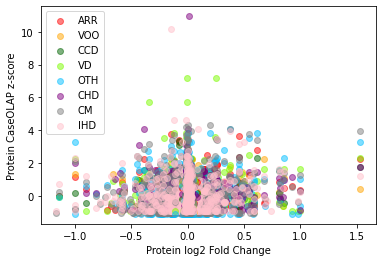

In [128]:
#ploting average fold change against caseolap values for both experiments (in same plot)

import matplotlib.pyplot as plt
import math
from scipy.stats import pearsonr
from statistics import mean
import numpy as np

a = 0.5

plt.scatter(PXD008934_fold_changes[0], PXD008934_caseolap_zscores[0], c= "red", alpha = a)
plt.scatter(PXD008934_fold_changes[0], PXD008934_caseolap_zscores[1], c= "orange", alpha = a)
plt.scatter(PXD008934_fold_changes[0], PXD008934_caseolap_zscores[2], c= "darkgreen", alpha = a)
plt.scatter(PXD008934_fold_changes[0], PXD008934_caseolap_zscores[3], c= "lawngreen", alpha = a)
plt.scatter(PXD008934_fold_changes[0], PXD008934_caseolap_zscores[4], c= "deepskyblue", alpha = a)
plt.scatter(PXD008934_fold_changes[0], PXD008934_caseolap_zscores[5], c= "purple", alpha = a)
plt.scatter(PXD008934_fold_changes[0], PXD008934_caseolap_zscores[6], c= "gray", alpha = a)
plt.scatter(PXD008934_fold_changes[0], PXD008934_caseolap_zscores[7], c= "pink", alpha = a)

plt.scatter(PXD023778_fold_changes[0], PXD023778_caseolap_zscores[0], c= "red", alpha = a)
plt.scatter(PXD023778_fold_changes[0], PXD023778_caseolap_zscores[1], c= "orange", alpha = a)
plt.scatter(PXD023778_fold_changes[0], PXD023778_caseolap_zscores[2], c= "darkgreen", alpha = a)
plt.scatter(PXD023778_fold_changes[0], PXD023778_caseolap_zscores[3], c= "lawngreen", alpha = a)
plt.scatter(PXD023778_fold_changes[0], PXD023778_caseolap_zscores[4], c= "deepskyblue", alpha = a)
plt.scatter(PXD023778_fold_changes[0], PXD023778_caseolap_zscores[5], c= "purple", alpha = a)
plt.scatter(PXD023778_fold_changes[0], PXD023778_caseolap_zscores[6], c= "gray", alpha = a)
plt.scatter(PXD023778_fold_changes[0], PXD023778_caseolap_zscores[7], c= "pink", alpha = a)

#labeling the axes
plt.xlabel("Protein log2 Fold Change")
plt.ylabel("Protein CaseOLAP z-score")

#creating the legen
cvds = zscores_df.columns
cvds = set(cvds)
print(cvds)

disease_categories = []

for cvd in cvds:
    disease_categories.append(cvd)

plt.legend(disease_categories, loc="best")

# #adding the lines of best fit (calculate the line using absolute values of the fold change)

# #separating the x and y values into different arrays
# x_vals_fit = []
# y_vals_fit = []

# #appending the x values (fold change values)
# for abs_value in PXD008934_fold_changes[1]:
#     for i in range(len(PXD008934_caseolap_zscores)):
#         x_vals_fit.append(abs_value)
# for abs_value in PXD023778_fold_changes[1]:
#     for i in range(len(PXD023778_caseolap_zscores)):
#         x_vals_fit.append(abs_value)
    
# #appending the y values (caseOLAP z-scores)
# for k in range(len(PXD008934_caseolap_zscores[0])):
#     for i in range(len(PXD008934_caseolap_zscores)):
#         y_vals_fit.append(PXD008934_caseolap_zscores[i][k])
# for k in range(len(PXD023778_caseolap_zscores[0])):
#     for i in range(len(PXD023778_caseolap_zscores)):
#         y_vals_fit.append(PXD023778_caseolap_zscores[i][k])
        
# #getting rid of nans
# x_no_nans = []
# y_no_nans = []
        
# for i in range(len(y_vals_fit)):
#     if not math.isnan(y_vals_fit[i]):
#         if not math.isnan(x_vals_fit[i]):
#             x_no_nans.append(x_vals_fit[i])
#             y_no_nans.append(y_vals_fit[i])

# x_no_nans = np.array(x_no_nans)
# y_no_nans = np.array(y_no_nans)
# print(len(x_no_nans))
# print(len(y_no_nans))
# #calculating equation for line of best fit
# a, b = np.polyfit(x_no_nans, y_no_nans, 1)
 
# #add line of best fit to plot
# plt.plot(x_no_nans, a*x_no_nans+b)

# #extending line of best fit
# p1 = np.polyfit(x_no_nans, y_no_nans, 1)
# xlims = plt.xlim()
# x_no_nans = np.insert(x_no_nans, 0, xlims[0])
# y_no_nans = np.insert(y_no_nans, 0, np.polyval(p1, xlims[0]))
# x_no_nans = np.append(x_no_nans, xlims[1])
# y_no_nans = np.append(y_no_nans, np.polyval(p1, xlims[1]))
# plt.plot(x_no_nans, np.polyval(p1,x_no_nans), 'k-', linewidth = 1.5)
# plt.xlim(xlims)

# #calculating Pearson’s correlation coefficient 
# corr, _ = pearsonr(x_no_nans, y_no_nans)
# print('Pearsons correlation: %.3f' % corr)
        
#plotting the plot
plt.show()

### In this section I will compare the fold change values with the average of the CaseOLAP scores for the proteins present in each pathway. This will be done for each pathway in each of the eight cardiovascular disease categories as well. 

In [129]:
#uploading all reactome pathways file
! wget https://reactome.org/download/current/UniProt2Reactome_All_Levels.txt

--2023-03-24 03:56:36--  https://reactome.org/download/current/UniProt2Reactome_All_Levels.txt
Resolving reactome.org (reactome.org)... 100.25.71.177
Connecting to reactome.org (reactome.org)|100.25.71.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113331978 (108M) [text/plain]
Saving to: ‘UniProt2Reactome_All_Levels.txt.4’

UniProt2Reactome_Al 100%[===================>] 108.08M  23.6MB/s    in 5.0s    

2023-03-24 03:56:41 (21.5 MB/s) - ‘UniProt2Reactome_All_Levels.txt.4’ saved [113331978/113331978]



In [130]:
#Differential Expression Reactome Analysis
diff_reg_prolif_regen_pathways = pd.read_csv("ReactomeResults_DiffReg.csv")
#diff_reg_prolif_regen_pathways

#obtaining a list of just pathway names
diff_exp_pathway_list = []
diff_exp_pathway_list = diff_reg_prolif_regen_pathways["Name"].values.tolist()
len(diff_exp_pathway_list)

1336

In [131]:
#creating a dict to map the unirefs to their uniprots
uniref_to_uniprot_list = {}
uniprot_to_uniref_list = {}
for uniref_list, uniprot_list in zip(caseolap_summary_table['Protein Groups'], caseolap_summary_table['Mapped Proteins']):
    uniref_l = uniref_list.split("; ")
    uniprot_l = uniprot_list.split("; ")
    for uniref_id in uniref_l:
        uniref_to_uniprot_list[uniref_id] = uniprot_l
    for uniprot_id in uniprot_l:
        uniprot_to_uniref_list[uniprot_id] = uniref_l

#uniref_to_uniprot_list
uniprot_to_uniref_list

{'F8W930': ['UniRef90_Q9Y6M1', 'UniRef90_Q5SF07-2'],
 'Q9Y6M1': ['UniRef90_Q9Y6M1', 'UniRef90_Q5SF07-2'],
 'F1SFK0': ['UniRef90_Q9Y6M1', 'UniRef90_Q5SF07-2'],
 'B1AUU8': ['UniRef90_A0A2K6R5I6', 'UniRef90_P42566', 'UniRef90_S4R3U1'],
 'P42566': ['UniRef90_A0A2K6R5I6', 'UniRef90_P42566', 'UniRef90_S4R3U1'],
 'S4R3U1': ['UniRef90_A0A2K6R5I6', 'UniRef90_P42566', 'UniRef90_S4R3U1'],
 'F1SID7': ['UniRef90_F1SID7'],
 'A0A0A0MSR2': ['UniRef90_Q96D30',
  'UniRef90_E7EV99',
  'UniRef90_D6RJE2',
  'UniRef90_H0YG19',
  'UniRef90_P35611',
  'UniRef90_H0Y9H2',
  'UniRef90_G3I0J3',
  'UniRef90_D6RF25'],
 'E7EV99': ['UniRef90_Q96D30',
  'UniRef90_E7EV99',
  'UniRef90_D6RJE2',
  'UniRef90_H0YG19',
  'UniRef90_P35611',
  'UniRef90_H0Y9H2',
  'UniRef90_G3I0J3',
  'UniRef90_D6RF25'],
 'D6RJE2': ['UniRef90_Q96D30',
  'UniRef90_E7EV99',
  'UniRef90_D6RJE2',
  'UniRef90_H0YG19',
  'UniRef90_P35611',
  'UniRef90_H0Y9H2',
  'UniRef90_G3I0J3',
  'UniRef90_D6RF25'],
 'H0YG19': ['UniRef90_Q96D30',
  'UniRef90_E7E

In [132]:
#dictionary to map proteins to their caseOLAP z-scores

# extract only the scores as a new df
zscores_df = caseolap_summary_table[caseolap_summary_table.columns[0:11]]
zscores_df = zscores_df.drop(['Protein Groups','Synonyms'],axis=1)
zscores_df = zscores_df.set_index('Mapped Proteins')
zscores_df = zscores_df.T

#protein to score dictionary
prots_to_scores = zscores_df.to_dict()
prots_to_scores

{'F8W930; Q9Y6M1; F1SFK0': {'IHD': nan,
  'CM': -0.4528496373142793,
  'ARR': nan,
  'VD': -0.2144508998258696,
  'CHD': nan,
  'CCD': nan,
  'VOO': nan,
  'OTH': nan},
 'B1AUU8; P42566; S4R3U1': {'IHD': -0.7161083718613064,
  'CM': -0.7664053043772605,
  'ARR': nan,
  'VD': nan,
  'CHD': nan,
  'CCD': nan,
  'VOO': nan,
  'OTH': nan},
 'F1SID7': {'IHD': 0.1091628750714541,
  'CM': 3.5116197033909686,
  'ARR': 0.923204002817157,
  'VD': 7.245176596323781,
  'CHD': 1.0988640157695615,
  'CCD': 0.4921130822195248,
  'VOO': -0.7086444995098988,
  'OTH': 2.1799166778055064},
 'A0A0A0MSR2; E7EV99; D6RJE2; H0YG19; P35611; E7ENY0; H0Y9H2; D6RAH3; D6RF25': {'IHD': 0.745009206378672,
  'CM': -1.0156010476108692,
  'ARR': nan,
  'VD': nan,
  'CHD': -0.8276498593807459,
  'CCD': nan,
  'VOO': nan,
  'OTH': -0.3184816487145289},
 'E9PKI8; E9PM01; F2Z393': {'IHD': nan,
  'CM': -0.0918468572895704,
  'ARR': nan,
  'VD': nan,
  'CHD': nan,
  'CCD': nan,
  'VOO': nan,
  'OTH': -1.084649127754764},
 'I

In [133]:

'''
This function reports the set of proteins corresponding to a pathway_id found in the input file. This
information is found in the reactome_uniprot_to_pathway_file table downloaded from the Reactome
website. Exclude isoforms removes protein accession which correspond to a protein isoform, reporting
only the cannonical protein accession instead.
'''


def extract_pathway_name_to_proteins(reactome_uniprot_to_pathway_file,
                                exclude_isoforms=True):
    # Load file for mapping reactome id -> proteins
    reactome_uniprot_to_pathway_table = pd.read_csv(reactome_uniprot_to_pathway_file, sep='\t', header=None)
    reactome_uniprot_to_pathway_table.columns = ["Uniprot", "Pathway identifier", "URL", "Pathway name", "X",
                                                 "Organism"]

    # add all proteins to each pathway set
    pathway_to_unique_proteins = {}
    for protein, pathway_id, pathway_name in zip(reactome_uniprot_to_pathway_table['Uniprot'],
                                reactome_uniprot_to_pathway_table['Pathway identifier'],
                                reactome_uniprot_to_pathway_table['Pathway name']):
        if "HSA" in pathway_id:
            # initialize set for each pathway
            if pathway_name not in pathway_to_unique_proteins:
                pathway_to_unique_proteins[pathway_name] = set()
            pathway_to_unique_proteins[pathway_name].add(protein)

    # remove protein isoforms
    if exclude_isoforms:
        for pathway in pathway_to_unique_proteins.keys():

            # identify isoforms
            isoforms = set()
            for protein in pathway_to_unique_proteins[pathway]:
                if "-" in protein:
                    isoforms.add(protein)

            # remove isoforms and add base protein
            for protein in isoforms:
                base_protein = protein.split("-")[0]
                pathway_to_unique_proteins[pathway].remove(protein)
                pathway_to_unique_proteins[pathway].add(base_protein)

    # Information about what we gathered
    num_proteins_per_pathway = []
    for pathway in pathway_to_unique_proteins.keys():
        proteins = pathway_to_unique_proteins[pathway]
        num_proteins_per_pathway += [len(proteins)]
    num_proteins_frequency = {x: num_proteins_per_pathway.count(x) for x in num_proteins_per_pathway}
    num_pathways_with_non_zero_proteins = 0
    for i in num_proteins_frequency.keys():
        freq = num_proteins_frequency[i]
        if i > 0:
            num_pathways_with_non_zero_proteins += freq
    arr = np.array(num_proteins_per_pathway)
    mean_num_proteins = np.mean(arr)
    median_num_proteins = np.median(arr)
    stdev_num_proteins = np.std(arr)

    # Describe the data
    print("Number of pathways extracted: " + str(len(pathway_to_unique_proteins)))
    print("Number of pathways extracted with > 0 proteins: " + str(num_pathways_with_non_zero_proteins))
    print("Mean pathway size: " + str(mean_num_proteins))
    print("Median pathway size: " + str(median_num_proteins))
    print("Standard deviation pathway size: " + str(stdev_num_proteins))

    return pathway_to_unique_proteins



reactome_uniprot_to_pathway_file="UniProt2Reactome_All_Levels.txt"
pathway_to_proteins = extract_pathway_name_to_proteins(reactome_uniprot_to_pathway_file,
                                            exclude_isoforms = False)


Number of pathways extracted: 2574
Number of pathways extracted with > 0 proteins: 2574
Mean pathway size: 50.113053613053616
Median pathway size: 16.0
Standard deviation pathway size: 143.66696426315264


In [134]:
pathway_to_proteins['Pre-NOTCH Processing in Golgi']

{'O00587',
 'O14983',
 'P09958',
 'P15291',
 'P16615',
 'P20340',
 'P46531',
 'Q04721',
 'Q11203',
 'Q11206',
 'Q15363',
 'Q8NES3',
 'Q93084',
 'Q99466',
 'Q9UBV2',
 'Q9UM47',
 'Q9Y274',
 'Q9Y644'}

In [135]:
#this function maps each of thhe pathways above to each of their proteins' caseOLAP z-scores
def extract_pathway_to_scores(pathways_extracted, 
                              uniref_to_uniprot, 
                              zscores_df, 
                              uniprot_to_uniref, 
                              pathway_to_proteins):

    #for each pathway in the diff_path_file, get the mapped proteins from the main reactome file
    pathway_to_score_dict = {}
    protein_to_score = {}
    
    #converting zscores_df to a dictionary
    prots_to_scores = zscores_df.to_dict()

    #going through every differentially expressed pathway
    for pathway in pathways_extracted:
        if pathway in pathway_to_proteins:

            #getting each protein in that pathway
            for protein in pathway_to_proteins[pathway]:

                #if that protein has unirefs that are mapped to caseolap scores
                if protein in uniprot_to_uniref_list:

                    #get the list of proteins that would be associated with that score in the zscores dataframe
                    mapped_uniref = uniprot_to_uniref[protein][0]

                    protein_key = uniref_to_uniprot_list[mapped_uniref]
                    protein_key = "; ".join(protein_key)

                    if pathway not in pathway_to_score_dict:
                        pathway_to_score_dict[pathway] = {}
                        
                    pathway_to_score_dict[pathway][protein_key] = prots_to_scores[protein_key]

    return pathway_to_score_dict

pathway_to_score = extract_pathway_to_scores(diff_exp_pathway_list, 
                              uniref_to_uniprot_list, 
                              zscores_df, 
                              uniprot_to_uniref_list, 
                              pathway_to_proteins)

pathway_to_score['Pre-NOTCH Processing in Golgi']

{'P16615; O55143': {'IHD': nan,
  'CM': 0.1348431910458757,
  'ARR': -0.5952270173926576,
  'VD': nan,
  'CHD': -0.5349696393064447,
  'CCD': nan,
  'VOO': nan,
  'OTH': 0.0401900633026774},
 'F6PXC7; Q99466': {'IHD': nan,
  'CM': nan,
  'ARR': nan,
  'VD': nan,
  'CHD': 0.8383824701643737,
  'CCD': nan,
  'VOO': nan,
  'OTH': nan},
 'O14983; H3BTW4; H3BVB2': {'IHD': nan,
  'CM': -0.7664196614639024,
  'ARR': nan,
  'VD': nan,
  'CHD': nan,
  'CCD': nan,
  'VOO': nan,
  'OTH': nan},
 'Q15363': {'IHD': -0.7163934292761578,
  'CM': -0.4531429097980266,
  'ARR': -0.5953830679618022,
  'VD': nan,
  'CHD': 0.8761000275557207,
  'CCD': -0.6675703802112133,
  'VOO': nan,
  'OTH': -0.8019637106466395},
 'P46531': {'IHD': -0.3754680549177649,
  'CM': 0.2224063275410192,
  'ARR': nan,
  'VD': 2.612731222535225,
  'CHD': 2.62400692321293,
  'CCD': nan,
  'VOO': 2.590606208241253,
  'OTH': -1.0961203384083815},
 'Q93084': {'IHD': nan,
  'CM': -1.0153160194957902,
  'ARR': nan,
  'VD': nan,
  'CHD'

In [136]:
#checking results of Pre-NOTCH Processing in Golgi
cvds = []

for proteins in pathway_to_score.values():
    for cvd in proteins.values():
        for cvd_name in cvd.keys():
            cvds.append(cvd_name)

cvds = set(cvds)

all_caseolap_averages = []
for cvd in cvds:
    
    caseolaps = []
    for scores in pathway_to_score['Pre-NOTCH Processing in Golgi'].values():
        caseolaps.append(scores[cvd])
        
    av_caseolap = np.nanmean(caseolaps)
    
    print(cvd)
    print(av_caseolap)

ARR
-0.59530504267723
VOO
2.590606208241253
CCD
-0.6675703802112133
VD
2.612731222535225
OTH
-0.6192979952507812
CHD
0.5952406430261764
CM
-0.37552581443416483
IHD
-0.5459307420969614


In [137]:
import numpy as np

#for each pathway, this function extracts the average of the caseOLAP scores of their proteins (for each cvd)
def extract_caseOLAP_averages(pathway_to_score, differential_pathways_df):
    
    #extracting the names of all of the disease categories
    cvds = []
    
    for proteins in pathway_to_score.values():
        for cvd in proteins.values():
            for cvd_name in cvd.keys():
                cvds.append(cvd_name)

    cvds = set(cvds)

    all_caseolap_averages = []
    for cvd in cvds:
        #print(cvd)
        average_cvd = []
        for pathway in differential_pathways_df['Name']:
            if pathway in pathway_to_score:
                caseolaps = []
                for scores in pathway_to_score[pathway].values():
                    caseolaps.append(scores[cvd])
                #if np.nanmean(caseolaps) > 4:
                    #print(pathway)
                    #print(np.nanmean(caseolaps))
                av_caseolap = np.nanmean(caseolaps)
                average_cvd.append(av_caseolap)
        all_caseolap_averages.append(average_cvd)

    return all_caseolap_averages

extract_caseOLAP_averages = extract_caseOLAP_averages(pathway_to_score, diff_reg_prolif_regen_pathways)

len(extract_caseOLAP_averages)

/tmp/ipykernel_3675/3656308157.py:28: RuntimeWarning: Mean of empty slice
  av_caseolap = np.nanmean(caseolaps)


8

In [138]:
#extracting the fold change values for each pathway

def extracting_fold_change(differential_pathways_df):

    #extracting the average fold changes for the pathways in both files 
    pathway_to_avfc =  differential_pathways_df
    pathway_to_avfc = pathway_to_avfc[['Name','av_foldchange.PXD023778', 'av_foldchange.PXD008934']]
    pathway_to_avfc = pathway_to_avfc.set_index('Name')
    avg_foldchanges = pathway_to_avfc.to_dict()

    #extracting the y values for the plot
    all_foldchanges = []
    fold_change_file = []

    for file in avg_foldchanges:
        fold_change_file.append(file)

    for file in fold_change_file:
        file_averages = []
        for pathway in differential_pathways_df['Name']:
                if pathway in pathway_to_score:
                    file_averages.append(avg_foldchanges[file][pathway])
        all_foldchanges.append(file_averages)

    return all_foldchanges

extracting_fold_change = extracting_fold_change(diff_reg_prolif_regen_pathways)
len(extracting_fold_change)

2

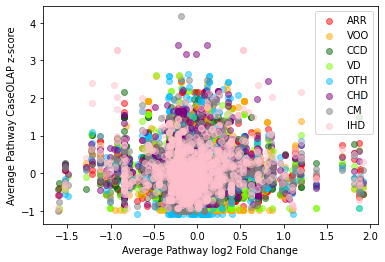

In [139]:
#creating a plot
import matplotlib.pyplot as plt

a = 0.5

plt.scatter(extracting_fold_change[0], extract_caseOLAP_averages[0], c= "red",   alpha = a)
plt.scatter(extracting_fold_change[0], extract_caseOLAP_averages[1], c= "orange",   alpha = a)
plt.scatter(extracting_fold_change[0], extract_caseOLAP_averages[2], c= "darkgreen",   alpha = a)
plt.scatter(extracting_fold_change[0], extract_caseOLAP_averages[3], c= "lawngreen",   alpha = a)
plt.scatter(extracting_fold_change[0], extract_caseOLAP_averages[4], c= "deepskyblue",   alpha = a)
plt.scatter(extracting_fold_change[0], extract_caseOLAP_averages[5], c= "purple",   alpha = a)
plt.scatter(extracting_fold_change[0], extract_caseOLAP_averages[6], c= "gray",   alpha = a)
plt.scatter(extracting_fold_change[0], extract_caseOLAP_averages[7], c= "pink",   alpha = a)


plt.scatter(extracting_fold_change[1], extract_caseOLAP_averages[0], c= "red",  alpha = a)
plt.scatter(extracting_fold_change[1], extract_caseOLAP_averages[1], c= "orange",  alpha = a)
plt.scatter(extracting_fold_change[1], extract_caseOLAP_averages[2], c= "darkgreen",  alpha = a)
plt.scatter(extracting_fold_change[1], extract_caseOLAP_averages[3], c= "lawngreen",  alpha = a)
plt.scatter(extracting_fold_change[1], extract_caseOLAP_averages[4], c= "deepskyblue",  alpha = a)
plt.scatter(extracting_fold_change[1], extract_caseOLAP_averages[5], c= "purple",  alpha = a)
plt.scatter(extracting_fold_change[1], extract_caseOLAP_averages[6], c= "gray",  alpha = a)
plt.scatter(extracting_fold_change[1], extract_caseOLAP_averages[7], c= "pink",  alpha = a)

#labeling the axes
plt.xlabel("Average Pathway log2 Fold Change")
plt.ylabel("Average Pathway CaseOLAP z-score")

#creating the legend
cvds = zscores_df.index
cvds = set(cvds)

disease_categories = []

for cvd in cvds:
    disease_categories.append(cvd)

plt.legend(disease_categories, loc="best")

# #adding the lines of best fit (calculate the line using absolute values of the fold change)

# #separating the x and y values into different arrays
# x_vals_fit = []
# y_vals_fit = []

# #appending the x values (fold change values)
# for value in extracting_fold_change[0]:
#     for i in range(len(extract_caseOLAP_averages)):
#         x_vals_fit.append(value)
# for value in extracting_fold_change[1]:
#     for i in range(len(extract_caseOLAP_averages)):
#         x_vals_fit.append(value)
    
# #appending the y values (caseOLAP z-scores)
# for k in range(len(extract_caseOLAP_averages[0])):
#     for i in range(len(extract_caseOLAP_averages)):
#         y_vals_fit.append(extract_caseOLAP_averages[i][k])
# for k in range(len(extract_caseOLAP_averages[1])):
#     for i in range(len(extract_caseOLAP_averages)):
#         y_vals_fit.append(extract_caseOLAP_averages[i][k])
        
# #getting rid of nans
# x_no_nans = []
# y_no_nans = []
        
# for i in range(len(y_vals_fit)):
#     if not math.isnan(y_vals_fit[i]):
#         if not math.isnan(x_vals_fit[i]):
#             x_no_nans.append(x_vals_fit[i])
#             y_no_nans.append(y_vals_fit[i])

# x_no_nans = np.array(x_no_nans)
# y_no_nans = np.array(y_no_nans)
# x_no_nans = np.absolute(x_no_nans)
# print(len(x_no_nans))
# print(len(y_no_nans))

# #calculating equation for line of best fit
# a, b = np.polyfit(x_no_nans, y_no_nans, 1)
 
# #add line of best fit to plot
# plt.plot(x_no_nans, a*x_no_nans+b)

# #extending line of best fit
# p1 = np.polyfit(x_no_nans, y_no_nans, 1)
# xlims = plt.xlim()
# x_no_nans = np.insert(x_no_nans, 0, xlims[0])
# y_no_nans = np.insert(y_no_nans, 0, np.polyval(p1, xlims[0]))
# x_no_nans = np.append(x_no_nans, xlims[1])
# y_no_nans = np.append(y_no_nans, np.polyval(p1, xlims[1]))
# plt.plot(x_no_nans, np.polyval(p1,x_no_nans), 'k-', linewidth = 1.5)
# plt.xlim(xlims)

# #calculating Pearson’s correlation coefficient 
# corr, _ = pearsonr(x_no_nans, y_no_nans)
# print('Pearsons correlation: %.3f' % corr)

#print the plot
plt.show()